## Построение базового бейслайна для задачи

**Данные:** подводные изображения + маски на 8 классов  
**Модель:** до 60 M параметров (можно запускать без интернета)  
**Метрики:** mIoU, Dice, mPA, PA  

### Почему это важно
Подводная робототехника и исследование океана требуют автоматической интерпретации изображений.  
Качественная сегментация помогает:
- Навигации автономных подводных аппаратов и дронов  
- Мониторингу коралловых рифов и оценке биоразнообразия  
- Поиску мусора, утечек и объектов на дне  

### Дальнейшие шаги
Это только базовый бейслайн.  
План развития:
- Добавление данных с помощью автоматической сегментации подводных изображений крупными моделями + кластаризация + классификация.  
- Дообучение на расширенном датасете  
- Увеличение разнообразия классов


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import numpy as np
import random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks"
test_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST"

О данных



Структура датасета:

Датасет разделён на две папки:

train_val - папка с тренировочными данными, TEST - пака с тестовыми данными.

В обоих папках есть по две папки: images и masks. Изображение и соответствующее ему маска имеют одинаковое название и разное расширение: jpg и bmp соотвественно.

Пример:

    - изображение, путь до изображение /train_val/images/d_r_103_.jpg
    
    - путь до маски: /train_val/masks/d_r_103_.bmp

-----------------------------------------------------------------------

Классы:

Фон (Background (waterbody))

Водолазы (Human divers)

Водные растения и морская трава (Aquatic plants and sea-grass)

Обломки и руины (Wrecks and ruins)

Роботы (AUVs/ROVs/инструменты) (Robots (AUVs/ROVs/instruments))

Рифы и беспозвоночные (Reefs and invertebrates)

Рыбы и позвоночные (Fish and vertebrates)

Морское дно и камни (Sea-floor and rocks)





In [ ]:
import os
# len(os.listdir('/kaggle/working/processed_dataset'))

## Анализ данных

1. **Распределение классов:**
   - Оценка баланса между классами, анализ их частоты.

2. **Определение шумов или артефактов в масках:**
   - Проверка масок на наличие дефектов, таких как разрывы или "мусорные" области.

3. **Определение пустых масок:**
   - Выявление масок, которые полностью состоят из фона (пустые).

4. **Проверка на содержание "лишних" классов в масках:**
   - Убедиться, что в масках отсутствуют классы, не заявленные авторами датасета.

In [ ]:
color_to_class = {
    (0, 0, 0): 0,      # Background (black)
    (0, 0, 255): 1,    # Human divers (blue)
    (0, 255, 0): 2,    # Aquatic plants (green)
    (0, 255, 255): 3,  # Wrecks and ruins (sky)
    (255, 0, 0): 4,    # Robots (red)
    (255, 0, 255): 5,  # Reefs and invertebrates (pink)
    (255, 255, 0): 6,  # Fish and vertebrates (yellow)
    (255, 255, 255): 7 # Sea-floor and rocks (white)
}

In [ ]:
import os
import cv2
import cupy as cp
# ТУТ ИСПОЛЬЗУЕТСЯ CuPy, поэтому при запуске на CPU будет ошибка. Используйте только GPU
def old_distib_calc(mask_dir, color_to_class=color_to_class):
    """
    Вычисляет распределение классов по пикселям во всех масках с использованием GPU (CuPy).

    :param mask_dir: путь к директории с масками.
    :param color_to_class: словарь маппинга RGB -> класс.
    :return: словарь {класс: количество пикселей}.
    """
    class_distribution = {}

    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)

        # Читаем маску (оставляем в формате BGR, но это не критично)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        if mask is None:
            print(f"Ошибка чтения маски: {mask_path}")
            continue

        # Загружаем маску на GPU
        mask_gpu = cp.asarray(mask)

        # Создаём пустую карту классов (на GPU)
        class_mask = cp.zeros(mask_gpu.shape[:2], dtype=cp.uint8)

        # Преобразуем RGB -> классы на GPU
        for rgb, cls in color_to_class.items():
            rgb_gpu = cp.array(rgb, dtype=cp.uint8)
            match_mask = cp.all(mask_gpu == rgb_gpu, axis=-1)  # Быстрое сравнение на GPU
            class_mask[match_mask] = cls  # Записываем класс в маску

        # Подсчёт уникальных классов и их количества на GPU
        unique_classes, counts = cp.unique(class_mask, return_counts=True)

        # Обновляем распределение классов (переносим на CPU)
        unique_classes = unique_classes.get()
        counts = counts.get()

        for cls, count in zip(unique_classes, counts):
            class_distribution[cls] = class_distribution.get(cls, 0) + count

    return class_distribution

# Рассчитываем распределение классов
train_mask_dir = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks'
test_mask_dir = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/masks'

test_old_distrib = old_distib_calc(test_mask_dir)
train_old_distrib = old_distib_calc(train_mask_dir)
print("Распределение классов:", train_old_distrib)


In [ ]:
def calc_class_weights(distrib_dataframe):
    # Вычисляем class_weights на основе инверсного логарифма частот классов
    class_weights = 1 / np.log1p(distrib_dataframe["Percentage"])

    # Нормализуем веса так, чтобы максимальный вес стал 5.0 (остальные пропорционально растянуты)
    # Это нужно, чтобы избежать слишком маленьких значений (например, 0.1-0.3), которые слабо влияют на обучение.
    # Выбранный диапазон [0.5, 5.0] хорошо компенсирует дисбаланс, но не создаёт нестабильность.
    class_weights /= class_weights.max()/5
    return class_weights

In [ ]:
import matplotlib.pyplot as plt


test_old_distrib = {0: 16478278, 3: 2666704, 5: 7674390, 2: 1215617, 7: 6699903, 1: 354299, 4: 1454049, 6: 2871016}

# предыдущий код достаточно долго работает ввиду сложности работы с форматом bmp, поэтому результат:
train_old_distrib = {
    0: 189688979, 1: 2917692, 3: 39309599, 4: 12313599,
    5: 186100654, 7: 78415339, 6: 37353994, 2: 11940788
}

In [ ]:
def create_dataframe(distrib_dict):
    distrib_dict = pd.DataFrame(list(distrib_dict.items()), columns=["Class", "Pixel Count"])
    distrib_dict["Percentage"] = (distrib_dict["Pixel Count"] / distrib_dict["Pixel Count"].sum()) * 100
    distrib_dict = distrib_dict.sort_values(by="Class").reset_index(drop=True)
    return distrib_dict

In [ ]:
import scipy.stats as stats
import numpy as np



def kl_divergence(distrib_dataframe):
    # Данные из датасета
    pixel_counts = distrib_dataframe['Pixel Count']
    # Преобразуем в вероятностное распределение (нормализация)
    prob_distribution = pixel_counts / np.sum(pixel_counts)

    # Равномерное распределение (для сравнения)
    uniform_distribution = np.ones_like(prob_distribution) / len(prob_distribution)

    # Вычисляем KL-дивергенцию
    kl_divergence = stats.entropy(prob_distribution, uniform_distribution)

    return kl_divergence


# Построение круговой диаграммы
def make_pipe_plot(distrib_dict): #distib_dict - pd.DataFrame



    if type(distrib_dict)==dict:
        distrib_dict = create_dataframe(distrib_dict)
    elif type(distrib_dict) == pd.DataFrame:
        pass
    else:
        print('Неподдерживаемый тип входного объета')


    class_names = [
        "Background",
        "Divers",
        "Aquatic plants",
        "Ruins",
        "Robots",
        "Reefs",
        "Fish",
        "Sea-floor"
    ]


    print(distrib_dict)

    print()
    print('-'*20)
    print()

    print('Коэфицент распределение:', kl_divergence(distrib_dict))

    print()
    print('-'*20)
    print()


    # Построение круговой диаграммы
    plt.figure(figsize=(8, 8))
    plt.pie(
        distrib_dict["Percentage"],
        labels=class_names,
        autopct="%1.1f%%",
        startangle=140,
        wedgeprops={"edgecolor": "black"}
    )

    # Заголовок
    plt.title("Распределение пикселей по классам (%)")

    # Отображение графика
    plt.show()


## Анализ распределение классов в тренировочном датасете

   Class  Pixel Count  Percentage
0      0    189688979   33.991965
1      1      2917692    0.522846
2      2     11940788    2.139770
3      3     39309599    7.044218
4      4     12313599    2.206577
5      5    186100654   33.348943
6      6     37353994    6.693777
7      7     78415339   14.051905

--------------------

Коэфицент распределение: 0.5089130254135539

--------------------



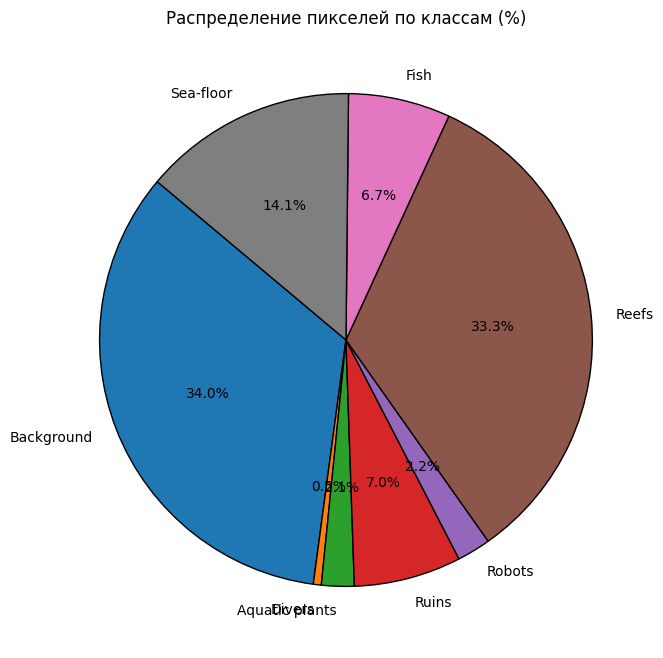

In [ ]:
make_pipe_plot(train_old_distrib)

### Вывод: В данных наблюдается заметный дисбаланс с преобладанием 0 класса (фон). Интерпретация значения Kl-divergence: 0.5 - высокое значение. Потребуется работа с дисбалансом.

## Анализ распределение классов в тестовом датасете

In [ ]:
make_pipe_plot(test_old_distrib)

### Вывод: В данных наблюдается заметный дисбаланс с преобладанием 0 класса (фон). Интерпретация значения Kl-divergence: 0.45 - высокое значение. Т.к. эти данные относятся тестовому, что нужен только для оценки модели, то для корректной её оценки следует смотреть метрики модели по каждому классу отдельно. Если точность модели на редких классах не сильно отличается от преобладающих, значит мы успешно обучили модель, иначе это потребует коллосального пересмотра процесса обучения.

In [ ]:
# анализ распределение размеров изображений
import os
import pandas as pd
from PIL import Image

image_folder = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/images"

def size_distrib(image_folder):
    data = []

    # Перебираем файлы в папке
    for filename in os.listdir(image_folder):
        file_path = os.path.join(image_folder, filename)

        # Проверяем, является ли файл изображением (по расширению)
        if filename.lower().endswith(('.jpg', '.png')):
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    data.append([filename, f"({width},{height})"])
            except Exception as e:
                print(f"Ошибка при обработке")

    # Создаём DataFrame
    df = pd.DataFrame(data, columns=["Filename", "Size"])
    print(df.Size.value_counts())

# size_distrib(image_folder)

## 📌 Вывод  

- В датасете **заметный дисбаланс классов** (**KL-дивергенция = 0.5**).  

## 📌 План решения  

1️⃣ **Применить Weighted Cross-Entropy Loss** для компенсации дисбаланса.  
2️⃣ **При недостаточном эффекте**:  
   - Увеличить данные редких классов через **фокусированные кропы**.  
   - **Фильтровать дублирующиеся кропы**, чтобы избежать переобучения.  
   - **Аугментации** (флипы, CutMix, MixUp) для редких классов.  
   - **Oversampling/Undersampling** (дублирование редких, удаление частых классов).  
3️⃣ **Оценить эффект по KL-дивергенции**.  
   - Если улучшений мало → протестировать **Focal Loss**.  

In [ ]:
# # анализ: есть ли среди пикселей масок лишний класс
# valid_classes = [0, 1, 2, 3, 4, 5, 6, 7]
# unique_classes = set(distribution.keys())
# invalid_classes = [cls for cls in unique_classes if cls not in valid_classes]
# if invalid_classes:
#     print(f"Недопустимые классы: {invalid_classes}")
# else:
#     print("Недопустимых классов не обнаруженно")

In [ ]:
# есть ли пары изображение-маска, где изобржаения и маска имеют разные размеры
def check_mask_image_sizes(image_dir, mask_dir):
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, image_file.replace('.jpg', '.bmp'))

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)

        if image.shape[:2] != mask.shape[:2]:
            print(f"Несоответствие размеров: {image_file}. Размер изображения {image.shape[:2]}, размер маски {mask.shape[:2]}")

# train_image_dir = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/images'
# train_masks_dir = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks'
# check_mask_image_sizes(train_image_dir, train_masks_dir)

In [ ]:
# анализ: есть среди данных пустые маски
def check_empty_masks(mask_dir):
    no_empty_mask=True
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if np.all(mask == 0):
            no_empty_mask=False
            print(f"Пустая маска: {mask_file}")
    if no_empty_mask:
        print('Не найдено не одной пустой маски')
# check_empty_masks('/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks')

In [ ]:
import scipy.ndimage as ndi

# есть ли среди данных шумные маски
def check_noise_in_masks(mask_dir):
    etalon_data = True
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        labeled_mask, num_features = ndi.label(mask > 0)
        if num_features > 5000:  # Условие для слишком мелких объектов
            print(f"В маске {mask_file} слишком много объектов ({num_features})")
            etalon_data=False
    if etalon_data:
        print('Шумов или артефактов в масках не обнаруженно')


# check_noise_in_masks('/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks')

In [ ]:
def show_random_image_and_mask(image_dir, mask_dir, num_examples=5):
    """
    Показывает случайные пары изображений и масок.

    :param image_dir: Путь к папке с изображениями.
    :param mask_dir: Путь к папке с масками.
    :param num_examples: Количество примеров для отображения.
    """
    # Получаем список файлов изображений
    image_files = os.listdir(image_dir)

    # Выбираем случайные файлы
    random_files = random.sample(image_files, num_examples)

    for file_name in random_files:
        # Путь к изображению и маске
        image_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name.replace('.jpg', '.bmp'))  # Заменяем расширение

        # Загружаем изображение и маску
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Преобразуем изображение в RGB для отображения
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Отображаем изображение и маску
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Изображение")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Маска")
        plt.axis("off")

        plt.show()

# Пример использования
# image_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/images"  # Замените на путь к изображениям
# mask_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks"    # Замените на путь к маскам
# show_random_image_and_mask(image_dir, mask_dir, num_examples=5)

# Вывод о качестве данных

## Данные имеют хорошее качество:
- Все маски корректны, пустых масок и шумов не обнаружено.

## Проблемы:
1. **Несоответствие размеров:**
   - Выявлено 37 масок (~2,3%), размеры которых не совпадают с размерами изображений.
2. **Дисбаланс классов:**
   - Некоторые классы сильно доминируют, тогда как другие представлены слабо.

## Решения:
1. **Несоответствие размеров:**
   - Исправить проблему на этапе масштабирования изображений и масок, приведя их к единому размеру.
2. **Дисбаланс классов:**
   - Использовать взвешенную функцию потерь, которая учитывает распределение классов для корректного обучения модели.


# Этап предобработки

# 📌 Балансировка классов через **resize + crop**  

## 🔹 Проблема  
Изначальное распределение классов было **неравномерным** (**KL-дивергенция = 0.5**).  
Для улучшения баланса был выбран метод **resize + crop**, позволяющий увеличить представленность редких классов.  

## 🔹 Подход  
- **Resize с сохранением пропорций**, чтобы привести изображения к единому формату.  
- **Кропинг** с приоритетом редких классов:  
  - Чем больше редких классов в кропе, тем выше шанс его сохранения.  
  - Ограничение на **перекрытие кропов (IoU)**, чтобы избежать дубликатов.  

## 🔹 Преимущества  
✅ **Увеличиваем разнообразие данных**, сохраняя пропорции объектов.  
✅ **Повышаем представленность редких классов**, удаляя лишние фоновые области.  
✅ **Контролируем дублирование** через фильтрацию похожих кропов.  

### 📌 Ожидаемый результат  
Метод должен **уменьшить KL-дивергенцию** за счёт лучшего распределения классов и улучшенной генерации обучающих данных.  
Если снижение KL-дивергенции **будет недостаточным**, возможны дальнейшие улучшения через аугментации или oversampling.  

In [ ]:
import cv2


# на вход подаётся изображение и маска
# шаг 1: определяем меньшую сторону
# шаг 2: маштабируем её до target_size
# шаг 3: сохраняя пропорции матшабируем большую сторону
# результат: изображение и маска размера (h, 512) или (512, w)
# плюсы подхода: решена проблема несоотвествие размеров изображение и масок у 37 экземляров

def resize_by_shorter_side(image, mask,target_size=512):
    h, w = image.shape[:2]  # Получаем размеры

    min_side_size = min(h, w)

    # Вычисляем коэффициент масштабирования
    scale = target_size / min_side_size

    # Вычисляем новый размер
    new_w, new_h = int(w * scale), int(h * scale)

    # Изменяем размер изображения
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    resized_mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    return resized_image, resized_mask


# img_path = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/images/d_r_189_.jpg"
# mask_path = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks/d_r_189_.bmp"
# image = cv2.imread(img_path)
# mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

# print("Новый размер изображения:", image.shape)
# resized_image, resized_mask = resize_by_shorter_side(image, mask)

# # Проверка размеров
# print("Новый размер изображения:", resized_image.shape)
# print("Новый размер изображения:", resized_image.shape)

In [ ]:
import numpy as np
import cv2
import os

# Пути
OUTPUT_DIR_masks = "/kaggle/working/processed_dataset/masks"
OUTPUT_DIR_images = "/kaggle/working/processed_dataset/images"
os.makedirs(OUTPUT_DIR_masks, exist_ok=True)
os.makedirs(OUTPUT_DIR_images, exist_ok=True)
def calculate_class_distribution(mask, crop_coords, threshold=15):
    """
    Подсчитывает количество пикселей каждого класса в кропе.

    Args:
        mask (numpy array): Маска (H, W).
        crop_coords (tuple): Координаты (x1, y1, x2, y2).
        threshold (int): Минимальное количество пикселей, чтобы учитывать класс.

    Returns:
        dict: Словарь {класс: количество пикселей}, отфильтрованный по threshold.
    """
    x1, y1, x2, y2 = crop_coords
    cropped_mask = mask[y1:y2, x1:x2]
    unique, counts = np.unique(cropped_mask, return_counts=True)

    # Создаём словарь {класс: количество пикселей} и фильтруем по threshold
    class_distribution = {cls: cnt for cls, cnt in zip(unique, counts) if cls > 0 and cnt >= threshold}

    return class_distribution

def compute_iou(crop1, crop2):
    """
    Вычисляет IoU между двумя кропами.

    Args:
        crop1 (tuple): (x1, y1, x2, y2) для первого кропа.
        crop2 (tuple): (x1, y1, x2, y2) для второго кропа.

    Returns:
        float: Значение IoU (0.0 - 1.0).
    """
    x1, y1, x2, y2 = crop1
    x1_, y1_, x2_, y2_ = crop2

    inter_x1 = max(x1, x1_)
    inter_y1 = max(y1, y1_)
    inter_x2 = min(x2, x2_)
    inter_y2 = min(y2, y2_)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    area1 = (x2 - x1) * (y2 - y1)
    area2 = (x2_ - x1_) * (y2_ - y1_)

    iou = inter_area / float(area1 + area2 - inter_area)
    return iou

def get_dynamic_iou(mask, crop_size):
    """
    Определяет порог IoU на основе размера объекта.

    Args:
        mask (numpy array): Маска кропа.
        crop_size (int): Размер кропа.

    Returns:
        float: Порог IoU (0.3 - 0.7).
    """
    object_pixels = np.count_nonzero(mask)  # Количество пикселей объекта
    object_ratio = object_pixels / (crop_size * crop_size)  # Доля объекта в кропе

    if object_ratio > 0.5:  # Объект занимает больше 50% кропа
        return 0.7
    elif object_ratio > 0.3:  # Средний объект (30-50%)
        return 0.6
    else:  # Маленький объект (менее 30%)
        return 0.5

def class_score(mask, crop_coords, class_weights):
    """
    Вычисляет оценку кропа по балансу классов.

    Args:
        mask (numpy array): Маска изображения.
        class_weights (dict): {класс: вес} - веса классов.

    Returns:
        float: Оценка (чем выше, тем лучше).
    """
    class_distribution = calculate_class_distribution(mask, crop_coords)
    score = sum(class_weights.get(cls, 0) * count for cls, count in class_distribution.items())
    return score

def resolve_overlap(c1, c2, crop_size, long_size, mask, existing_crops, class_weights):
    """
    Разрешает пересечение двух кропов, предлагая три варианта и выбирая лучший по IoU и балансу классов.

    Args:
        c1 (int): Центр первого кропа.
        c2 (int): Центр второго кропа.
        crop_size (int): Размер кропа.
        long_size (int): Длина длинной стороны изображения.
        mask (numpy array): Маска изображения.
        existing_crops (list): Список уже добавленных кропов.
        class_weights (dict): Веса классов (id_класса -> вес).

    Returns:
        int: Выбранный центр кропа.
    """
    C_avg = int((c1 + c2) / 2)
    C_left = int((C_avg + c1) / 2)
    C_right = int((C_avg + c2) / 2)

    # Проверка границ
    def valid_center(center):
        return crop_size // 2 <= center <= long_size - crop_size // 2

    possible_centers = [C_avg, C_right, C_left]
    possible_centers = [c for c in possible_centers if valid_center(c)]

    best_center = C_avg
    best_score = -np.inf  # Максимизируем

    # Проверяем IoU и баланс классов
    for center in possible_centers:
        crop_coords = (center - crop_size // 2, 0, center + crop_size // 2, mask.shape[0])

        iou_violated = any(compute_iou(crop_coords, existing_crop) > get_dynamic_iou(mask, crop_size) for existing_crop in existing_crops)
        if iou_violated:
            continue

        # Считаем оценку баланса классов
        crop_mask = mask[:, crop_coords[0]:crop_coords[2]]
        score = class_score(crop_mask, crop_coords, class_weights)

        if score > best_score:
            best_score = score
            best_center = center

    return best_center


def generate_crops(image, mask, crop_size):
    """
    Генерирует кропы по фиксированным центрам.

    Args:
        image (numpy array): Входное изображение (H, W, C).
        mask (numpy array): Входная маска (H, W).
        crop_size (int): Размер выходного кропа (X, X).

    Returns:
        list: Список (кроп изображения, кроп маски).
    """
    h, w = mask.shape
    long_size = max(h, w)
    short_size = min(h, w)

    unique_classes = np.unique(mask)
    unique_classes = unique_classes[unique_classes > 0]  # Исключаем фон

    N = len(unique_classes)  # Количество классов в маске

    # Определяем диапазон возможных центров
    min_center = crop_size // 2
    max_center = long_size - crop_size // 2

    # Генерируем равноудалённые центры
    centers = np.linspace(min_center, max_center, N).astype(int)

    # Обрабатываем пересечения

    final_centers = []
    existing_crops = []  # Храним уже добавленные кропы

    for i, center in enumerate(centers):
        if i > 0 and abs(center - final_centers[-1]) < crop_size // 10:
            center = resolve_overlap(final_centers[-1], center, crop_size, long_size, mask, existing_crops, class_weights)
            final_centers[-1] = center  # Заменяем последний центр
        else:
            final_centers.append(center)

    crops = []
    short_center = short_size // 2

    crop_coords = []

    for center in final_centers:
        if w > h:  # Горизонтальные изображения
            x1 = max(0, center - crop_size // 2)
            x2 = x1 + crop_size
            y1, y2 = short_center - crop_size // 2, short_center + crop_size // 2
        else:  # Вертикальные изображения
            y1 = max(0, center - crop_size // 2)
            y2 = y1 + crop_size
            x1, x2 = short_center - crop_size // 2, short_center + crop_size // 2

        # Создаём координаты текущего кропа
        current_crop = (x1, y1, x2, y2)

        # Проверяем IoU со всеми существующими кропами
        iou_violated = any(compute_iou(current_crop, existing_crop) > get_dynamic_iou(mask, crop_size) for existing_crop in existing_crops)

        if not iou_violated:  # Добавляем кроп, если IoU не превышает порог
            crop_coords.append(current_crop)
            existing_crops.append(current_crop)  # Добавляем в список существующих кропов

            # Обрезаем изображение и маску
            crop_img = image[y1:y2, x1:x2]
            crop_mask = mask[y1:y2, x1:x2]

            crops.append((crop_img, crop_mask))



    # Для теста
    # for i in range(len(crop_coords)):
    #     for j in range(i + 1, len(crop_coords)):
    #         iou = compute_iou(crop_coords[i], crop_coords[j])
    #         print(f"IoU между кропами {i} и {j}: {iou:.2f}")



    return crops



In [ ]:
# class_weights = calc_class_weights(create_dataframe(test_old_distrib))

In [ ]:
# class_weights

In [ ]:
import threading
import time


# Применение к датасету
# DATASET_PATH = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val"  # Укажи путь к SUIM
# # IMAGE_DIR = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val/images'
# # MASK_DIR = os.path.join(DATASET_PATH, "masks")
# IMAGE_DIR = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images'
# MASK_DIR = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/masks'

# PROCESSED_DIR = '/kaggle/working/processed_dataset'


# processed_count = 0


# # Функция для вычисления размера папки
# def get_folder_size(path):
#     total_size = 0
#     for dirpath, _, filenames in os.walk(path):
#         for f in filenames:
#             fp = os.path.join(dirpath, f)
#             total_size += os.path.getsize(fp)
#     return total_size / (1024 ** 2)  # Переводим в MB

# # Функция для отслеживания прогресса



# stop_thread = False
# # Функция для отслеживания прогресса
# def track_progress():
#     global stop_thread
#     while not stop_thread:
#         folder_size = get_folder_size(PROCESSED_DIR)
#         size_str = f"{folder_size:.2f} MB" if folder_size < 1024 else f"{folder_size / 1024:.2f} GB"
#         print(f"🔄 Обработано {processed_count} изображений, занято {size_str}...")
#         time.sleep(10)  # Обновляем каждые 10 секунд


# # Запускаем мониторинг в отдельном потоке
# progress_thread = threading.Thread(target=track_progress, daemon=True)
# progress_thread.start()

# for img_name in os.listdir(IMAGE_DIR):
#     img_path = os.path.join(IMAGE_DIR, img_name)
#     mask_path = os.path.join(MASK_DIR, img_name.replace(".jpg", ".bmp"))

#     image = cv2.imread(img_path)
#     raw_mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

#     mask = np.zeros(raw_mask.shape[:2], dtype=np.uint8)
#     for rgb, cls in color_to_class.items():
#         mask[np.all(raw_mask == rgb, axis=-1)] = cls

#     if image is None or mask is None:
#         continue

#     # Выполняем resize
#     resized_image, resized_mask = resize_by_shorter_side(image, mask)

#     target_size = min(resized_image.shape[:2])  # Это X, который мы использовали для ресайза

#     # Генерируем фиксированные кропы
#     crops = generate_crops(resized_image, resized_mask, crop_size=target_size)


#     # print(len(crops))
#     # Сохраняем кропы
#     for i, (crop_img, crop_mask) in enumerate(crops):

#         filename = os.path.splitext(img_name)[0]
#         crop_img_path = os.path.join(OUTPUT_DIR_images, f"{filename}_crop_{i}.jpg")
#         crop_mask_path = os.path.join(OUTPUT_DIR_masks, f"{filename}_crop_{i}.png")

#         cv2.imwrite(crop_img_path, crop_img)
#         cv2.imwrite(crop_mask_path, crop_mask)
#     processed_count += 1


# stop_thread = True
# progress_thread.join()
# print("✅ Обработка завершена. Мониторинг остановлен.")
# print(f"Кропы масок сохранены в {OUTPUT_DIR_masks}")
# print(f"Кропы изображдений сохранены в {OUTPUT_DIR_images}")

In [ ]:
# !zip -r processed_dataset.zip /kaggle/working/processed_dataset

# Анализ распределение в новых данных после метода resize+crop

In [ ]:
train_image_folder = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/kaggle/working/processed_dataset/images"
test_image_folder = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/test/kaggle/working/processed_dataset/images"
# size_distrib(test_image_folder)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def new_distib_calc(mask_dir):
    """
    Подсчитывает распределение пикселей по классам во всех масках в указанной папке.

    Аргументы:
        mask_dir (str): Путь к папке с масками.

    Возвращает:
        pandas.DataFrame: Таблица с количеством пикселей для каждого класса.
    """
    class_counts = defaultdict(int)  # Словарь для хранения количества пикселей

    # Обход всех файлов в папке
    for filename in os.listdir(mask_dir):
        if filename.endswith(".png"):  # Проверяем, что файл - маска
            mask_path = os.path.join(mask_dir, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Читаем маску в градациях серого

            if mask is None:
                continue

            unique, counts = np.unique(mask, return_counts=True)  # Подсчет количества пикселей каждого класса
            for u, c in zip(unique, counts):
                class_counts[u] += c  # Добавляем к общему количеству пикселей

    # Создание DataFrame
    df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Pixel Count"])
    df["Percentage"] = (df["Pixel Count"] / df["Pixel Count"].sum()) * 100
    df = df.sort_values(by="Class").reset_index(drop=True)

    return df


    return df


# train_mf = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/test/kaggle/working/processed_dataset/masks"
# test_mf = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/masks"
# new_train_cd = new_distib_calc(train_mf)
# new_test_cd = new_distib_calc(test_mf)

KeyboardInterrupt: 

In [ ]:
# make_pipe_plot(new_train_cd)

In [ ]:
# make_pipe_plot(new_test_cd)

### Вывод: kl-devirgence уменьшилось с 0.5 до 0.47, что можно назвать незначительными изменениями.

## **Балансировка классов через оценку важности изображений**  

### **Проблема**  
Метод **resize + crop** дал незначительное улучшение: KL-дивергенция снизилась с **0.5 → 0.47**. Это показало, что он **недостаточно эффективен** для балансировки классов.  

### **Новый подход**  
1. Рассчитывается **"важность"** изображения:  
   - Чем больше **редких классов**, тем выше **вес изображения**.  
2. Балансировка датасета:  
   - **Удаляем n наименее важные изображения** (с частыми классами).  
   - **Дублируем m наиболее важные изображения** (с редкими классами).  

### **Преимущества**  
✅ Уменьшаем дисбаланс без лишнего увеличения данных.  
✅ Простая и управляемая стратегия.  
✅ Улучшаем представленность редких классов.  




In [ ]:
# new_test_cd

In [ ]:
# class_weights = calc_class_weights(new_train_cd)

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import os
import numpy as np
import pandas as pd
from PIL import Image

def calculate_image_importance(mask_folder, class_weights):
    """
    Оценивает важность каждого изображения на основе количества пикселей каждого класса.

    :param mask_folder: Путь к папке с масками.
    :param class_weights: Словарь {класс: вес}, определяющий значимость каждого класса.
    :return: DataFrame с именем файла, важностью и количеством пикселей каждого класса.
    """
    image_scores = []

    # Определяем уникальные классы (на основе class_weights)
    all_classes = sorted(class_weights.keys())

    for filename in os.listdir(mask_folder):
        file_path = os.path.join(mask_folder, filename)

        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            try:
                # Загружаем маску и конвертируем в numpy array
                mask = np.array(Image.open(file_path))

                # Получаем количество пикселей каждого класса
                unique, counts = np.unique(mask, return_counts=True)
                class_pixel_counts = dict(zip(unique, counts))

                # Вычисляем "важность" изображения
                importance_score = sum(class_pixel_counts.get(cls, 0) * class_weights.get(cls, 1) for cls in class_weights)

                # Создаём запись с количеством пикселей для каждого класса
                row = [filename.replace('.png', ''), importance_score] + [class_pixel_counts.get(cls, 0) for cls in all_classes]

                image_scores.append(row)

            except Exception as e:
                print(f"Ошибка при обработке {filename}: {e}")

    # Создаём DataFrame с нужными колонками
    columns = ["Filename", "Importance"] + [f"Class_{cls}" for cls in all_classes]
    df_importance = pd.DataFrame(image_scores, columns=columns)

    # Сортируем по важности
    df_importance = df_importance.sort_values(by="Importance", ascending=False).reset_index(drop=True)

    return df_importance

# --- Пример использования ---
# mask_folder - путь до папки с масками после custom resize+crop
# mask_folder = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/kaggle/working/processed_dataset/masks"

# df_importance = calculate_image_importance(mask_folder, class_weights)

In [ ]:
# df_importance

### Вывод:

![importance_dataset.png](attachment:16c7962a-2048-41b3-aee5-26c7da5d41e1.png)

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import entropy

import numpy as np
import pandas as pd
from scipy.stats import entropy

def balance_dataset(df_importance, num_duplicate=100, num_remove=100):
    """
    Балансирует датасет в рамках таблицы: дублирует важные изображения и удаляет менее важные.
    После этого пересчитывает KL-дивергенцию для нового распределения.

    :param df_importance: DataFrame с именем файла, важностью и количеством пикселей каждого класса.
    :param num_duplicate: Количество изображений, которые нужно продублировать.
    :param num_remove: Количество изображений, которые нужно удалить.
    :return: Новый DataFrame с перераспределением классов и KL-дивергенцией.
    """

    # 1. Удаляем num_remove наименее важные изображения
    df_balanced = df_importance.iloc[:-num_remove].copy()

    # 2. Дублируем num_duplicate самых важных изображений
    top_important = df_balanced.head(num_duplicate).copy()
    top_important["Filename"] = 'dup_' + top_important["Filename"]

    # 3. Добавляем дублированные данные в датасет
    df_balanced = pd.concat([df_balanced, top_important], ignore_index=True)

    # 4. Пересчитываем новое распределение классов
    class_columns = [col for col in df_balanced.columns if col.startswith("Class_")]
    new_class_distribution = df_balanced[class_columns].sum()

    # 5. Нормализуем новое распределение
    new_distribution = new_class_distribution.values
    new_distribution = new_distribution / np.sum(new_distribution)

    # 6. Вычисляем KL-дивергенцию (только для нового распределения)
    uniform_distribution = np.ones_like(new_distribution) / len(new_distribution)
    kl_div = entropy(new_distribution, uniform_distribution)

    # 7. Возвращаем обновлённую таблицу и KL-дивергенцию нового датасета
    return df_balanced, kl_div

# --- Пример использования ---

In [ ]:
# experiments = [
#     {"num_duplicate": 100, "num_remove": 100},  # Базовый тест
#     {"num_duplicate": 50, "num_remove": 50},    # Мягкая балансировка
#     {"num_duplicate": 200, "num_remove": 100},  # Агрессивный oversampling
#     {"num_duplicate": 100, "num_remove": 200},  # Агрессивный undersampling
#     {"num_duplicate": 300, "num_remove": 300}   # Максимальная балансировка
# ]


# for exp in experiments:
#     df_balanced, kl_div = balance_dataset(df_importance, **exp)
#     print(f"Experiment {exp}: KL-divergence = {kl_div:.5f}")

### Вывод:

![test_for_kl.png](attachment:db9458c3-7b99-4400-a37f-52ba5a85fed2.png)

## Вывод: Минимальное KL-divergence получаем при num_duplicate': 300, 'num_remove': 300

In [ ]:
# exp = {"num_duplicate": 300, "num_remove": 300}
# df_balanced, _ = balance_dataset(df_importance, **exp)

In [ ]:
# df_balanced

In [ ]:
import os
import shutil
import pandas as pd


# если есть возможность удалять файлы, то использовать данную функцию
# def apply_balancing_changes(image_folder, output_folder, df_balanced):
#     """
#     Реализует дублирование и удаление изображений на основе сбалансированного датасета.

#     :param image_folder: Папка с оригинальными изображениями.
#     :param output_folder: Папка для обновлённого датасета.
#     :param df_balanced: DataFrame с финальным списком изображений.
#     """

#     # Создаём выходную папку, если её нет
#     os.makedirs(output_folder, exist_ok=True)

#     # Список изображений, которые должны быть в новом датасете
#     keep_files = set(df_balanced["Filename"])

#     # 1. Перебираем файлы в папке и удаляем ненужные
#     for filename in os.listdir(image_folder):
#         file_path = os.path.join(image_folder, filename)
#         if filename not in keep_files:
#             os.remove(file_path)  # Удаляем лишние файлы

#     # 2. Дублируем нужные файлы (если они помечены как дубликаты)
#     for filename in df_balanced["Filename"]:
#         src_path = os.path.join(image_folder, filename)
#         dst_path = os.path.join(output_folder, filename)

#         # Копируем оригинальный файл в новую папку
#         if os.path.exists(src_path):
#             shutil.copy2(src_path, dst_path)

#         # Если это дубликат, создаём копию с "_dup"
#         if "_dup" in filename:
#             dup_path = os.path.join(output_folder, filename.replace("_dup", ""))
#             if os.path.exists(dup_path):
#                 shutil.copy2(dup_path, dst_path)

#     print("✅ Датасет обновлён: файлы удалены/добавлены по `df_balanced`.")


import os
import shutil
import pandas as pd


def create_balanced_dataset(source_folder, output_folder, df_balanced, files_format=".png"):
    """
    Создаёт новый сбалансированный датасет в kaggle/working/ на основе df_balanced.

    :param source_folder: Папка с оригинальными изображениями (Kaggle Datasets).
    :param output_folder: Папка, куда будут скопированы обновлённые данные (kaggle/working).
    :param df_balanced: DataFrame с финальным списком изображений.
    :param files_format: Формат файлов (например, '.png' или '.jpg').
    """

    # Создаём выходную папку, если её нет
    os.makedirs(output_folder, exist_ok=True)

    # 1. Копируем оригинальные файлы в новую папку
    for filename in df_balanced["Filename"]:
        original_filename = filename + files_format  # Добавляем формат файла
        src_path = os.path.join(source_folder, original_filename)
        dst_path = os.path.join(output_folder, original_filename)

        # Если файл оригинальный, копируем его
        if not filename.startswith("dup_"):
            if os.path.exists(src_path):
                shutil.copy2(src_path, dst_path)
            else:
                print(f"⚠️ Файл {original_filename} не найден в {source_folder}")

        # 2. Если файл — дубликат, создаём его копию в новом датасете
        else:
            original_base_name = filename.replace("dup_", "") + files_format
            original_path = os.path.join(source_folder, original_base_name)
            duplicate_path = os.path.join(output_folder, original_filename)

            if os.path.exists(original_path):
                shutil.copy2(original_path, duplicate_path)
            else:
                print(f"⚠️ Оригинал {original_base_name} не найден, не могу создать {original_filename}")

    print(f"✅ Новый датасет создан в: {output_folder}")



# # --- Создаём новый датасет для масок ---
# mask_folder = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/kaggle/working/processed_dataset/masks"
# output_folder = "/kaggle/working/final_dataset/masks"
# create_balanced_dataset(mask_folder, output_folder, df_balanced)

# # --- Создаём новый датасет для изображений ---
# mask_folder = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/kaggle/working/processed_dataset/images"
# output_folder = "/kaggle/working/final_dataset/images"
# create_balanced_dataset(mask_folder, output_folder, df_balanced, files_format='.jpg')

In [ ]:
# !zip -r processed_dataset.zip /kaggle/working/final_dataset

In [ ]:
# len(list(set(os.listdir('/kaggle/working/masks'))))

   Class  Pixel Count  Percentage
0      0    223708744   29.135580
1      1      4864102    0.633495
2      2     17934418    2.335759
3      3     64175735    8.358177
4      4     18917487    2.463793
5      5    259371499   33.780258
6      6     59505177    7.749889
7      7    119342614   15.543050

--------------------

Коэфицент распределение: 0.4474723179989576

--------------------



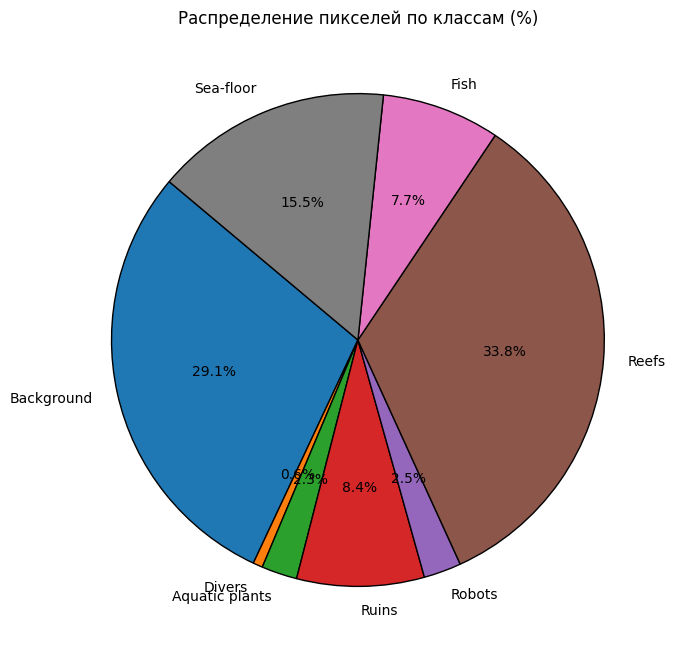

In [ ]:
mask_dir = '/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/masks'
final_train_cd = new_distib_calc(mask_dir)
make_pipe_plot(final_train_cd)

In [ ]:
# class_weights = calc_class_weights(final_train_cd)

# 📌 Балансировка датасета: от KL 0.5 → 0.44  

## 🔹 1. Начальное состояние  
- Датасет имел **сильный дисбаланс классов**.  
- **KL-дивергенция = 0.5**, что указывало на несбалансированное распределение.  
- Был протестирован метод **resize + crop**, но он дал **незначительное улучшение** (**KL 0.5 → 0.47**).  

## 🔹 2. Принятая стратегия балансировки  
- Разработан **метод оценки важности изображений** на основе состава классов.  
- **Важность** рассчитывалась по количеству **редких классов** в изображении.  
- **Удалены 300 наименее важные изображения**.  
- **Дублированы 300 наиболее важные изображения**.  
- После этого **KL-дивергенция снизилась до 0.447**.  

## 🔹 3. Финальные шаги  
- Для компенсации остаточного дисбаланса добавлен **Weighted Cross-Entropy Loss**.  
- Также протестирован **Focal Loss** для улучшения обучения редких классов.  
- Датасет **обновлён** и сохранён в `kaggle/working/` для обучения.  

## 🔹 Итог  
**Снижение KL-дивергенции с 0.5 → 0.44** показало, что баланс классов **значительно улучшился**.  
Дополнительные техники (взвешенный лосс, Focal Loss, аугментации) помогут **ещё сильнее компенсировать остаточный дисбаланс**.

## Данный датасет (resize+crop + oversampling/undersampling) доступен по ссылке https://www.kaggle.com/datasets/kehhill/suim-preprocessed-dataset-resized-and-cropped

In [ ]:
import random
import matplotlib.pyplot as plt
def show_random_image_and_mask(image_dir, mask_dir, num_examples=5):
    """
    Показывает случайные пары изображений и масок.

    :param image_dir: Путь к папке с изображениями.
    :param mask_dir: Путь к папке с масками.
    :param num_examples: Количество примеров для отображения.
    """
    # Получаем список файлов изображений
    image_files = os.listdir(image_dir)

    # Выбираем случайные файлы
    random_files = random.sample(image_files, num_examples)

    for file_name in random_files:
        # Путь к изображению и маске
        image_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name.replace('.jpg', '.png'))  # Заменяем расширение

        # Загружаем изображение и маску
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Преобразуем изображение в RGB для отображения
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Отображаем изображение и маску
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Изображение")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Маска")
        plt.axis("off")

        plt.show()

# # Пример использования
# image_dir = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/kaggle/working/final_dataset/images"  # Замените на путь к изображениям
# mask_dir = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/kaggle/working/final_dataset/masks"     # Замените на путь к маскам
# show_random_image_and_mask(image_dir, mask_dir, num_examples=5)

## Аугментация и кастомный генератор данных

## Аугментация данных

### 🔹 Геометрические трансформации (изображение + маска)
- `HorizontalFlip (p=0.5)` – случайное горизонтальное отражение.  
- `VerticalFlip (p=0.5)` – случайное вертикальное отражение.  
- `Rotate (limit=15, p=0.5)` – случайный поворот (-15°...+15°).  
- `Affine (shear=(-5,5), p=0.3)` – случайное сдвиговое искажение (shear).  
- **Применяются одинаково к изображению и маске**.

### 🔹 Цветовые трансформации (только изображение)
- `ColorJitter (brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.5)` – случайные цветовые искажения.  
- `RandomBrightnessContrast (brightness_limit=0.2, contrast_limit=0.2, p=0.5)` – случайная регулировка яркости и контраста.  
- `Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))` – нормализация под ImageNet.  

### 🔹 Логика применения
1. **Геометрические аугментации** применяются **сначала** (общие для изображения и маски).  
2. **Цветовые аугментации** – **после**, только для изображения.  
3. **Конвертация в тензоры** `(C, H, W)`, маска в `long`.  

🔥 **Сбалансированный набор аугментаций** для улучшения генерализации модели.

## Краткий анализ: насколько данные отличаются от тех, на которых обучалась модель

In [ ]:
# import numpy as np
# import cv2
# from glob import glob

# image_paths = glob("/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/kaggle/working/final_dataset/images/*.jpg")

# means = []
# stds = []

# for path in image_paths:
#     img = cv2.imread(path) / 255.0  # Нормируем в диапазон [0, 1]
#     means.append(np.mean(img, axis=(0, 1)))  # Среднее по каналам
#     stds.append(np.std(img, axis=(0, 1)))    # Стандартное отклонение по каналам

# mean = np.mean(means, axis=0)
# std = np.mean(stds, axis=0)

# print(f"Mean: {mean}, Std: {std}")

## Нормализация данных

Мои данные отличаются от ImageNet по mean/std, поэтому стандартная нормализация может быть не оптимальной.  
Пока оставляю ImageNet-нормализацию, так как модель обучена на этих статистиках.  

Если возникнут проблемы с обучением (нестабильные градиенты, плохая сходимость),  
имеет смысл адаптировать нормализацию под имеющиеся данные.

In [ ]:
class_weights = {
    0: 0.720441,
    1: 5.000000,
    2: 2.036698,
    3: 1.097198,
    4: 1.974953,
    5: 0.691343,
    6: 1.131196,
    7: 0.874426
}

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import cv2

import os
# Аугментации
geo_transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Горизонтальное отражение
    A.VerticalFlip(p=0.5),  # Вертикальное отражение
    A.Rotate(limit=15, p=0.5),  # Случайный поворот (-15°...+15°)
    A.Affine(shear={"x": (-5, 5), "y": (-5, 5)}, p=0.3),  # Волновые искажения (Shear)
], additional_targets={'mask': 'mask'})  # Применяем одинаково к маске и изображению

# 🔹 2. Цветовые аугментации (ТОЛЬКО для изображения)
color_transform = A.Compose([
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.5),  # Цветовые искажения
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Яркость + контраст
])

normalize = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

def test_augment(image, mask):
    image = normalize(image=image)['image']
    return image, mask



# 🔹 Функция аугментации
def train_augment(image, mask):
    """Сначала геометрические аугментации (общие), затем цветовые (только для изображения)."""

    # Применяем геометрические аугментации ОДНОВРЕМЕННО
    augmented = geo_transform(image=image, mask=mask)
    image, mask = augmented['image'], augmented['mask']

    # Применяем цветовые аугментации ТОЛЬКО к изображению
    image = color_transform(image=image)['image']
    image = normalize(image=image)['image']

    return image, mask

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import os

def get_image_mask_paths(image_dir, mask_dir, image_ext=".jpg", mask_ext=".png"):
    """
    Собирает список всех изображений и соответствующих масок из указанных папок.

    Args:
        image_dir (str): Путь к папке с изображениями.
        mask_dir (str): Путь к папке с масками.
        image_ext (str): Расширение файлов изображений (например, ".jpg", ".png").
        mask_ext (str): Расширение файлов масок (например, ".png", ".bmp").

    Returns:
        tuple: Два отсортированных списка с путями к изображениям и маскам.
    """

    # Получаем список файлов изображений и масок
    image_paths = sorted([
        os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
        if fname.endswith(image_ext)
    ])

    mask_paths = sorted([
        os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)
        if fname.endswith(mask_ext)
    ])

    return image_paths, mask_paths

# Пример использования
TRAIN_image_paths = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/images"
TRAIN_mask_paths = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/masks"


TEST_image_paths = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/test/kaggle/working/processed_dataset/images"
TEST_mask_paths = "/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/test/kaggle/working/processed_dataset/masks"

# train_image_paths и train_mask_paths содержат список всех путей до всех масок и изобржаений в папке
train_image_paths, train_mask_paths = get_image_mask_paths(TRAIN_image_paths, TRAIN_mask_paths)
test_image_paths, test_mask_paths = get_image_mask_paths(TEST_image_paths, TEST_mask_paths)
# # Проверяем первые 5 путей
print(train_image_paths[:5])
print(test_image_paths[:5])

['/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/images/d_r_103__crop_1.jpg', '/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/images/d_r_105__crop_0.jpg', '/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/images/d_r_105__crop_1.jpg', '/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/images/d_r_113__crop_0.jpg', '/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/with oversampling/kaggle/working/final_dataset/images/d_r_125__crop_0.jpg']
['/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/test/kaggle/working/processed_dataset/images/d_r_122__crop_0.jpg', '/kaggle/input/suim-preprocessed-dataset-resized-and-cropped/test/kaggle/working/processed_dataset/images/d_r_122__crop_1.jpg', '/kaggle/input/suim-preprocessed-dataset-resized-and-crop

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mode='test'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):


        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV читает в BGR, переводим в RGB
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)  # Загружаем маску в градациях серого

        # Применяем аугментацию

        if self.transform:
            image, mask = self.transform(image, mask)

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (H, W, C) → (C, H, W)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=train_augment, mode='train')
# # Используем drop_last=True, так как последний батч может быть слишком маленьким (batch_size=1),
# # а BatchNorm требует batch_size > 1. Мы разморозили BatchNorm для более стабильного обучения,
# # так как он помогает модели адаптироваться к статистике данных.
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=test_augment)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
# Заметка: num_workers при использование HDD не так полезен, как при использование SDD, т.к. он и так достаточно быстрый

# Этап обучения модели. Модель deeplab v3+ с Efficient net b3

In [ ]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=a2c4e9e1cfba7ae1992906e379887dc4d0644ad76b7825a73f8ce87e34c3d4cd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=47aefc2103c044e6f3d43d5f62bf2a519ebcfbbc3a0cf2e46b33054be1f1bf00
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import segmentation_models_pytorch as smp
from torchmetrics import JaccardIndex, Dice

## Выбор лосса и метрик

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """Focal Loss с поддержкой весов классов (передаются в виде словаря {id_class: weight})"""
    def __init__(self, gamma=2, class_weights=None, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.class_weights = class_weights
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")  # Вычисляем CE loss без редукции

        # Применяем веса классов (переводим словарь в тензор)
        if self.class_weights:
            class_weights_tensor = torch.tensor([self.class_weights[c] for c in range(inputs.shape[1])], device=inputs.device)
            weights = class_weights_tensor[targets]  # Выбираем веса для каждого пикселя
            ce_loss = ce_loss * weights  # Умножаем CE loss на веса классов

        pt = torch.exp(-ce_loss)  # Вычисляем p_t = exp(-CrossEntropy)
        focal_loss = (1 - pt) ** self.gamma * ce_loss  # Применяем модификатор сложности

        return focal_loss.mean() if self.reduction == "mean" else focal_loss.sum()

class DiceLoss(nn.Module):
    """Dice Loss для сегментации"""
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)  # Применяем softmax по каналам
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (inputs * targets).sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + self.smooth)

        return 1 - dice.mean()

class IoULoss(nn.Module):
    """IoU Loss (Jaccard Loss)"""
    def __init__(self, smooth=1.0):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (inputs * targets).sum(dim=(2, 3))
        union = (inputs + targets).sum(dim=(2, 3)) - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)

        return 1 - iou.mean()

class CombinedLoss(nn.Module):
    """Focal + Dice + IoU Loss с адаптивными весами"""
    def __init__(self, class_weights=None, gamma=2, dice_weight=1.0, iou_weight=0.5, adapt_weights=True):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(gamma=gamma, class_weights=class_weights)
        self.dice_loss = DiceLoss()
        self.iou_loss = IoULoss()

        self.dice_weight = dice_weight
        self.iou_weight = iou_weight
        self.adapt_weights = adapt_weights  # Включить адаптивное изменение весов

    def forward(self, inputs, targets, epoch=None, max_epochs=None):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        iou = self.iou_loss(inputs, targets)

        # Адаптивные веса: на старте важен Focal, потом IoU/Dice
        if self.adapt_weights and epoch is not None and max_epochs is not None:
            decay_factor = epoch / max_epochs
            dice_weight = self.dice_weight * (1 - decay_factor) + 0.1 * decay_factor  # Плавный переход
            iou_weight = self.iou_weight * decay_factor + 0.1 * (1 - decay_factor)  # IoU важнее позже
        else:
            dice_weight = self.dice_weight
            iou_weight = self.iou_weight

        return focal + dice_weight * dice + iou_weight * iou

# Пример использования
loss_fn = CombinedLoss(class_weights=class_weights, dice_weight=1.0, iou_weight=0.5)

In [ ]:
class SegmentationMetrics:
    """Класс для вычисления mIoU, Dice Score, Pixel Accuracy (PA), Mean Pixel Accuracy (mPA)"""

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def mIoU(self, preds, targets):
        iou_per_class = []

        for cls in range(self.num_classes):
            pred_mask = (preds == cls)
            target_mask = (targets == cls)

            intersection = (pred_mask & target_mask).sum(dim=(1, 2))
            union = (pred_mask | target_mask).sum(dim=(1, 2))

            # Проверяем, есть ли вообще этот класс в targets
            valid = target_mask.sum(dim=(1, 2)) > 0  # Булевый тензор [batch]

            if valid.any():  # Если класс есть в каком-то изображении
                iou = intersection[valid] / (union[valid] + 1e-7)
                iou_per_class.append(iou)

        return torch.cat(iou_per_class).mean() if iou_per_class else torch.tensor(0.0, device=targets.device)

    def dice_score(self, preds, targets):
        dice_per_class = []

        for cls in range(self.num_classes):
            pred_mask = (preds == cls).float()
            target_mask = (targets == cls).float()

            intersection = (pred_mask * target_mask).sum(dim=(1, 2))
            dice = (2. * intersection + 1e-7) / (pred_mask.sum(dim=(1, 2)) + target_mask.sum(dim=(1, 2)) + 1e-7)

            dice_per_class.append(dice)

        return torch.stack(dice_per_class).mean()

    def pixel_accuracy(self, preds, targets):
        correct = (preds == targets).sum()
        total = targets.numel()  # Все пиксели, включая фон

        return correct / (total + 1e-7)

    def mean_pixel_accuracy(self, preds, targets):
        per_class_acc = []

        for cls in range(self.num_classes):
            mask = (targets == cls)
            if mask.sum() > 0:  # Если в батче есть этот класс
                per_class_acc.append((preds[mask] == cls).float().mean())

        return torch.stack(per_class_acc).mean() if per_class_acc else torch.tensor(0.0, device=targets.device)



metrics = SegmentationMetrics(num_classes=8)

## Импортирование модели

In [ ]:
import segmentation_models_pytorch as smp

# Создаём DeepLabV3+ с backbone EfficientNet-b3 (можно выбрать другой)
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b3",  # Можно заменить на другую версию (b0, b1, ..., b7)
    encoder_weights="imagenet",  # Используем предобученные веса
    in_channels=3,  # Количество каналов входного изображения
    classes=8  # Количество классов на выходе (замени на своё)
)


In [ ]:
# Проверяем количество параметров
print(f"Параметров в модели: {sum(p.numel() for p in model.parameters())}")

decoder_params = sum(p.numel() for p in model.decoder.parameters()) + sum(p.numel() for p in model.segmentation_head.parameters())
encoder_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Параметры в энкодере (EfficientNet-b3): {encoder_params}")
print(f"Параметры в ASPP + декодере (DeepLabV3+): {decoder_params}")
print(f"Общее количество параметров: {encoder_params + decoder_params}")

In [ ]:
model.load_state_dict(torch.load('/kaggle/input/after30epoch/pytorch/default/2/model_weight (4)', weights_only=True))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## Стратегия обучения и оптимизатор

In [ ]:
bb_lr = 1e-5
max_backbone_lr = 5e-5
min_lr_bb = 1e-5

head_lr = 1e-4
max_head_lr = 1e-3
min_head_lr = 1e-4

wurm_up_epoch = 7

optimizer = optim.Adam([
    {"params": model.encoder.parameters(), "lr": bb_lr},  # EfficientNet-B3 backbone
    {"params": model.decoder.parameters(), "lr": head_lr}   # DeepLabV3+ head
])

def adjust_learning_rate(epoch, optimizer, loss_stagnation_n_epoch, wurm_up_end, bb_lr, head_lr,
                            wurm_up_epoch=wurm_up_epoch,
                            max_backbone_lr=max_backbone_lr, min_bb_lr=min_lr_bb,
                            max_head_lr=max_head_lr, min_head_lr=min_head_lr,
                            patience=5, koef=2):
    """Корректируем lr в зависимости от этапа обучения (warmup → peak → decay)"""

    stop_training = False

    if epoch == wurm_up_epoch:  # Warmup завершён, увеличиваем lr
        print("Окончание wurm up")
        for param_group in optimizer.param_groups:
            if param_group["lr"] == bb_lr:  # Backbone
                param_group["lr"] = max_backbone_lr   # Делаем резкий буст
                bb_lr = max_backbone_lr

            if param_group["lr"] == head_lr:  # Head
                param_group["lr"] = max_head_lr  # Делаем резкий буст
                head_lr = max_head_lr
        wurm_up_end = True
        loss_stagnation_n_epoch = 0


    if loss_stagnation_n_epoch==patience and wurm_up_end:

        if bb_lr > min_bb_lr:

            print(f'Превышен лимит эпох без улучшений. Страый lr backbone: {bb_lr}, старый lr head: {head_lr}')
            for param_group in optimizer.param_groups:

                if param_group["lr"] == bb_lr:  # Backbone
                    bb_lr = max(bb_lr / koef, min_bb_lr)  # Исправлено целочисленное деление
                    param_group["lr"] = bb_lr

                if param_group["lr"] == head_lr:  # Head
                    head_lr = max(head_lr / koef, min_head_lr)
                    param_group["lr"] = head_lr

            print(f'Превышен лимит эпох без улучшений. Новый lr backbone: {bb_lr}, новый lr head: {head_lr}')
            loss_stagnation_n_epoch = 0  # Сброс stagnation счётчика
        else:
            print(f'Сработала ранняя остановка.')
            stop_training = True

    return stop_training, loss_stagnation_n_epoch, wurm_up_end, head_lr, bb_lr

## Обучение

In [ ]:
import cv2
import numpy as np


def test_model(model, test_loader, device):
    model.eval()
    total_loss, total_miou, total_dice, total_pa, total_mpa = 0, 0, 0, 0, 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)


            loss = loss_fn(outputs, masks)


            preds = torch.argmax(outputs, dim=1)  # (B, H, W)


            total_loss += loss.item()
            total_miou += metrics.mIoU(preds, masks).item()
            total_dice += metrics.dice_score(preds, masks).item()
            total_pa += metrics.pixel_accuracy(preds, masks).item()
            total_mpa += metrics.mean_pixel_accuracy(preds, masks).item()

    avg_loss = total_loss / len(test_loader)
    avg_miou = total_miou / len(test_loader)
    avg_dice = total_dice / len(test_loader)
    avg_pa = total_pa / len(test_loader)
    avg_mpa = total_mpa / len(test_loader)

    return avg_loss, avg_miou, avg_dice, avg_pa, avg_mpa


test_avg_loss, test_avg_miou, test_avg_dice, test_avg_pa, test_avg_mpa = test_model(model, test_loader, device)
print(f"Test Results -> Loss: {test_avg_loss:.4f}, mIoU: {test_avg_miou:.4f}, "
        f"Dice: {test_avg_dice:.4f}, PA: {test_avg_pa:.4f}, mPA: {test_avg_mpa:.4f}")

Test Results -> Loss: 1.4174, mIoU: 0.6893, Dice: 0.7510, PA: 0.8362, mPA: 0.7648


In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, test_loader, optimizer, loss_fn, metrics, device, num_epochs, save_path='/kaggle/working/model_weight',
                 patience=5, head_lr=1e-3, bb_lr=1e-4):
    """
    Функция для тренировки модели с поддержкой AMP, early stopping и адаптивного LR.
    """

    end_epochs = 0
    best_test_miou = 0
    wurm_up_end = False
    loss_stagnation_n_epoch = 0

    scaler = GradScaler()  # AMP Scaler

    for epoch in range(end_epochs, num_epochs):
        stop_training, loss_stagnation_n_epoch, wurm_up_end, head_lr, bb_lr = \
            adjust_learning_rate(epoch, optimizer, loss_stagnation_n_epoch, wurm_up_end=wurm_up_end,
                                 head_lr=head_lr, bb_lr=bb_lr)

        if stop_training:
            break

        model.train()
        total_loss, total_miou, total_dice, total_pa, total_mpa = 0, 0, 0, 0, 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            with autocast():  # Mixed Precision
                outputs = model(images)
                loss = loss_fn(outputs, masks)

            scaler.scale(loss).backward()  # Масштабируем градиенты
            scaler.step(optimizer)  # Делаем шаг оптимизатора
            scaler.update()  # Обновляем скейлер

            preds = torch.argmax(outputs, dim=1)  # (B, H, W)

            total_loss += loss.item()
            total_miou += metrics.mIoU(preds, masks).item()
            total_dice += metrics.dice_score(preds, masks).item()
            total_pa += metrics.pixel_accuracy(preds, masks).item()
            total_mpa += metrics.mean_pixel_accuracy(preds, masks).item()

        train_avg_loss = total_loss / len(train_loader)
        train_avg_miou = total_miou / len(train_loader)
        train_avg_dice = total_dice / len(train_loader)
        train_avg_pa = total_pa / len(train_loader)
        train_avg_mpa = total_mpa / len(train_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] \n    Train Results -> Loss: {train_avg_loss:.4f}, mIoU: {train_avg_miou:.4f}, "
              f"Dice: {train_avg_dice:.4f}, PA: {train_avg_pa:.4f}, mPA: {train_avg_mpa:.4f}")

        test_loss, test_miou, test_dice, test_pa, test_mpa = test_model(model, test_loader, device)
        print(f"    Test Results -> Loss: {test_loss:.4f}, mIoU: {test_miou:.4f}, "
                f"Dice: {test_dice:.4f}, PA: {test_pa:.4f}, mPA: {test_mpa:.4f}")

        # Логика Early Stopping
        if test_miou > best_test_miou:
            loss_stagnation_n_epoch = 0
            best_test_miou = test_miou
            torch.save(model.state_dict(), save_path)  # Сохраняем лучшую модель
        else:
            loss_stagnation_n_epoch += 1


# train_model(model, train_loader, test_loader, optimizer, loss_fn, metrics, device, num_epochs, save_path='/kaggle/working/model_weight')

In [ ]:
# import torch
# from torch.cuda.amp import autocast, GradScaler

# num_epochs = 45
# end_epochs = 0
# patience = 5 # будет использоваться как для понижение Lr при стагнации лосса, так и для early_stopping если lr уже снижен до минимума
# best_test_miou = 0
# wurm_up_end=False
# loss_stagnation_n_epoch = 0



# scaler = GradScaler()  # Добавляем GradScaler для AMP

# for epoch in range(end_epochs, num_epochs):

#     stop_training, loss_stagnation_n_epoch, wurm_up_end, head_lr, bb_lr = adjust_learning_rate(epoch, optimizer, loss_stagnation_n_epoch, wurm_up_end=wurm_up_end, head_lr=head_lr, bb_lr=bb_lr)

#     if stop_training: break

#     model.train()
#     total_loss, total_miou, total_dice, total_pa, total_mpa = 0, 0, 0, 0, 0

#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)



#         optimizer.zero_grad()

#         with autocast():  # Mixed Precision
#             outputs = model(images)
#             loss = loss_fn(outputs, masks)

#         scaler.scale(loss).backward()  # Масштабируем градиенты
#         scaler.step(optimizer)  # Делаем шаг оптимизатора
#         scaler.update()  # Обновляем скейлер


#         preds = torch.argmax(outputs, dim=1)  # (B, H, W)

#         total_loss += loss.item()
#         total_miou += metrics.mIoU(preds, masks).item()
#         total_dice += metrics.dice_score(preds, masks).item()
#         total_pa += metrics.pixel_accuracy(preds, masks).item()
#         total_mpa += metrics.mean_pixel_accuracy(preds, masks).item()

#     train_avg_loss = total_loss / len(train_loader)
#     train_avg_miou = total_miou / len(train_loader)
#     train_avg_dice = total_dice / len(train_loader)
#     train_avg_pa = total_pa / len(train_loader)
#     train_avg_mpa = total_mpa / len(train_loader)


#     print(f"Epoch [{epoch+1}/{num_epochs}] \n    Train Results -> Loss: {train_avg_loss:.4f}, mIoU: {train_avg_miou:.4f}, "
#           f"Dice: {train_avg_dice:.4f}, PA: {train_avg_pa:.4f}, mPA: {train_avg_mpa:.4f}")

#     test_loss, test_miou, test_dice, test_pa, test_mpa = test_model(model, test_loader, device)
#     print(f"    Test Results -> Loss: {test_loss:.4f}, mIoU: {test_miou:.4f}, "
#             f"Dice: {test_dice:.4f}, PA: {test_pa:.4f}, mPA: {test_mpa:.4f}")
#     # Логика Early Stopping
#     if test_miou > best_test_miou:
#         loss_stagnation_n_epoch=0
#         best_test_miou = test_miou
#         torch.save(model.state_dict(), '/kaggle/working/model_weight')  # Сохраняем лучшую модель
#     else:
#         loss_stagnation_n_epoch+=1

## Тестирование и выводы

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

def test_model_per_class(model, test_loader, device, num_classes, class_names):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)

            preds = torch.argmax(outputs, dim=1)  # (B, H, W)

            total_loss += loss.item()

            # Collecting predictions and true labels for class-based metrics
            all_preds.append(preds.cpu().numpy())
            all_labels.append(masks.cpu().numpy())

    avg_loss = total_loss / len(test_loader)

    # Convert to numpy arrays for easier processing
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Initialize a list to hold the metrics for each class
    metrics_dict = {
        "Class Name": [],
        "IoU": [],
        "Dice": [],
        "PA": [],
        "mPA": []
    }

    # Calculate metrics for each class
    for class_id in range(num_classes):
        # Flatten arrays for each class
        y_true = (all_labels == class_id).flatten()
        y_pred = (all_preds == class_id).flatten()

        # Calculating confusion matrix values
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() if len(np.unique(y_true)) == 2 else (0, 0, 0, 0)

        # IoU (Intersection over Union)
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
        metrics_dict["IoU"].append(iou)

        # Dice Coefficient
        dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        metrics_dict["Dice"].append(dice)

        # Pixel Accuracy (PA)
        pa = tp / (tp + fn) if (tp + fn) > 0 else 0
        metrics_dict["PA"].append(pa)

        # Mean Pixel Accuracy (mPA)
        mpa = tp / (tp + fp) if (tp + fp) > 0 else 0
        metrics_dict["mPA"].append(mpa)

        # Adding class name
        metrics_dict["Class Name"].append(class_names[class_id])

    # Create a pandas DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame(metrics_dict)

    return avg_loss, metrics_df



# class_names = [
#         "Background",
#         "Divers",
#         "Aquatic plants",
#         "Ruins",
#         "Robots",
#         "Reefs",
#         "Fish",
#         "Sea-floor"
#     ]  # Названия классов

# test_avg_loss, metrics_df = test_model_per_class(model, test_loader, device, num_classes=len(class_names), class_names=class_names)

# # Печать результатов
# print(f"Test Loss: {test_avg_loss:.4f}")
# print("\nPer-Class Metrics:")
# print(metrics_df)

Test Loss: 1.4174

Per-Class Metrics:
       Class Name       IoU      Dice        PA       mPA
0      Background  0.860898  0.925250  0.937990  0.912852
1          Divers  0.779917  0.876352  0.877375  0.875331
2  Aquatic plants  0.351686  0.520366  0.439979  0.636695
3           Ruins  0.789155  0.882154  0.891855  0.872662
4          Robots  0.824617  0.903879  0.923184  0.885366
5           Reefs  0.619166  0.764796  0.792622  0.738857
6            Fish  0.692230  0.818127  0.740093  0.914557
7       Sea-floor  0.614210  0.761004  0.761037  0.760970


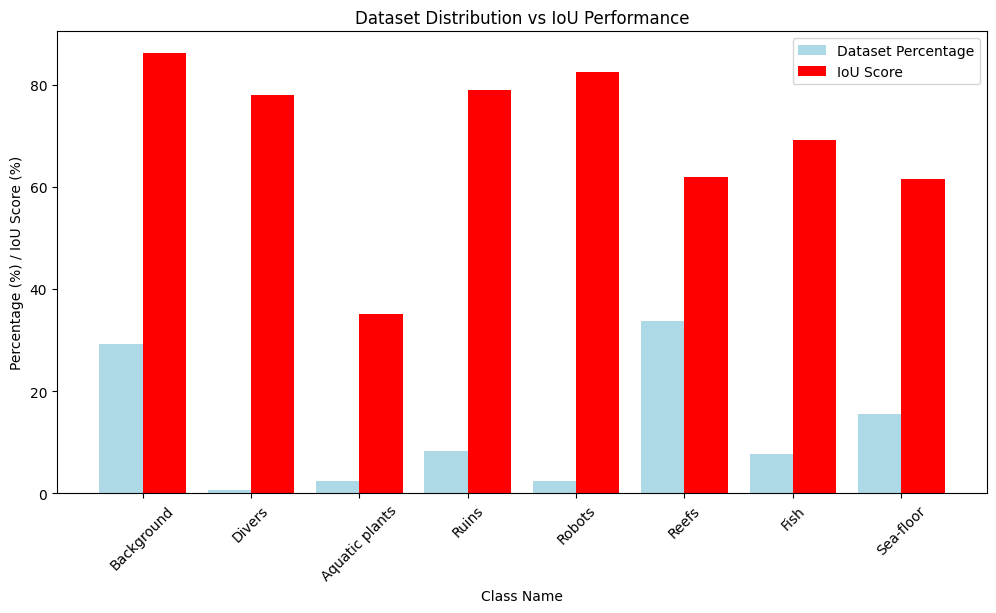

In [ ]:
# # final_train_cd = new_distib_calc(mask_dir)
# metrics_df["Percentage"] = final_train_cd["Percentage"]

# import numpy as np

# fig, ax = plt.subplots(figsize=(12, 6))

# x = np.arange(len(metrics_df["Class Name"]))  # Позиции для столбцов
# width = 0.4  # Ширина столбцов

# # Бар-график распределения пикселей по классам (синий)
# ax.bar(x - width/2, metrics_df["Percentage"], width, label="Dataset Percentage", color="lightblue")

# # Бар-график IoU по классам (красный)
# ax.bar(x + width/2, metrics_df["IoU"] * 100, width, label="IoU Score", color="red")

# # Подписи осей и графика
# ax.set_xlabel("Class Name")
# ax.set_ylabel("Percentage (%) / IoU Score (%)")
# ax.set_title("Dataset Distribution vs IoU Performance")
# ax.set_xticks(x)
# ax.set_xticklabels(metrics_df["Class Name"], rotation=45)
# ax.legend()

# # Показ графика
# plt.show()


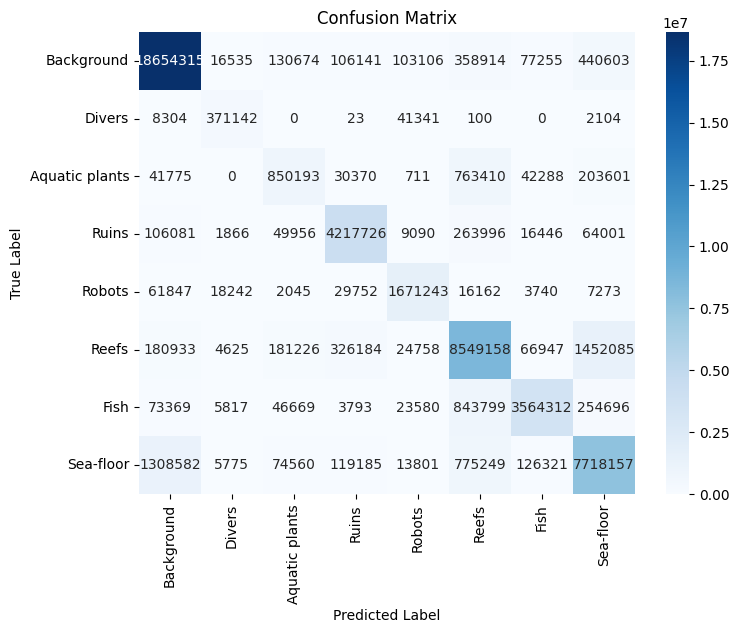

In [ ]:
# # Инициализация списков для хранения предсказаний и истинных меток
# all_preds = []
# all_labels = []
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Проход по тестовому датасету
# with torch.no_grad():
#     for images, masks in test_loader:
#         images, masks = images.to(device), masks.to(device)

#         # Предсказания модели
#         outputs = model(images)
#         preds = torch.argmax(outputs, dim=1)  # Получаем предсказанные классы

#         # Сохранение в списки
#         all_preds.append(preds.cpu().numpy())
#         all_labels.append(masks.cpu().numpy())

# # Конвертация всех предсказаний и масок в numpy-массивы
# all_preds = np.concatenate(all_preds, axis=0).flatten()
# all_labels = np.concatenate(all_labels, axis=0).flatten()

# # Вычисление матрицы ошибок
# conf_matrix = confusion_matrix(all_labels, all_preds)

# # Визуализация Confusion Matrix
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=metrics_df["Class Name"], yticklabels=metrics_df["Class Name"])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()


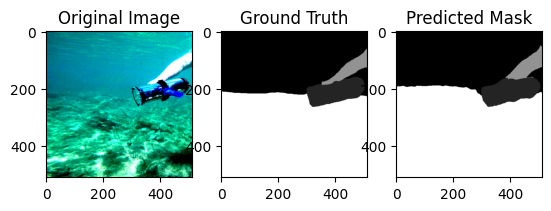

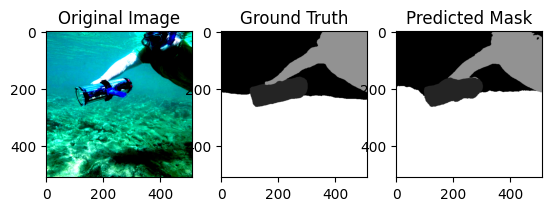

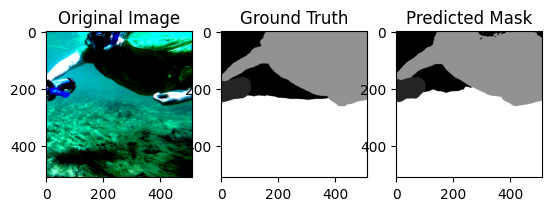

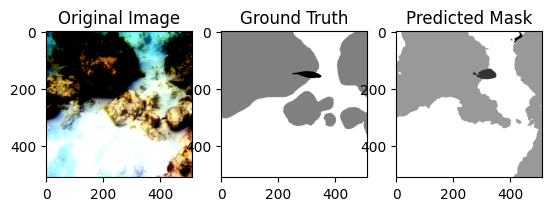

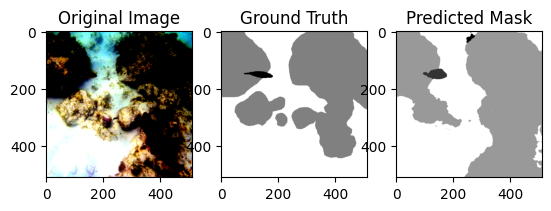

In [ ]:
# import matplotlib.pyplot as plt

# model.eval()
# images, masks = next(iter(test_loader))
# images = images.to(device)

# with torch.no_grad():
#     outputs = model(images)

# # Визуализация первых 5 предсказаний
# for i in range(5):

#     plt.subplot(1, 3, 1)
#     plt.imshow(images[i].cpu().permute(1, 2, 0))
#     plt.title("Original Image")

#     plt.subplot(1, 3, 2)
#     plt.imshow(masks[i].cpu().squeeze(), cmap="gray")
#     plt.title("Ground Truth")

#     plt.subplot(1, 3, 3)
#     plt.imshow(outputs[i].cpu().argmax(dim=0), cmap="gray")
#     plt.title("Predicted Mask")

#     plt.show()


# **Анализ результатов: влияние кастомного лосса на сегментацию SUIM**

## **1. Влияние Focal + Dice + IoU лосса**
Наш подход к функции потерь показал **успешные результаты**, особенно для классов с низкой представленностью в данных. Например:

- **Divers (0.63% пикселей)** – IoU **0.78**, Dice **0.88**, PA **0.88**.
- **Robots (2.46% пикселей)** – IoU **0.82**, Dice **0.90**, PA **0.92**.

Для малочисленных классов обычно характерна низкая точность предсказаний, но благодаря использованию **Focal Loss** (смещение внимания модели на сложные примеры) и **Dice + IoU Loss** (оптимизация именно на пересечении предсказаний с GT), удалось избежать проблем сильного игнорирования этих классов.

## **2. Проблема Aquatic Plants**
Однако класс **Aquatic Plants (2.33%)** демонстрирует **значительное проседание**:
- IoU **0.35**, Dice **0.52**, PA **0.44**.

На первый взгляд, можно было бы предположить, что причина в дисбалансе данных. Однако **Confusion Matrix** показывает, что проблема лежит глубже:  

- Модель предсказывает **Aquatic Plants** правильно **800,000** раз.  
- Однако модель предсказывает **Sea-Floor** вместо **"Aquatic Plants"** **750,000** раз.  
- Модель предсказывает **Reefs** вместо **Aquatic Plants** **200,000** раз.

Очевидно, что **низкий mIoU здесь не вызван недостатком примеров**, а скорее тем, что модель **путает "Aquatic Plants" с визуально схожими классами**. Это указывает на **недостаточную дискриминативность** признаков модели между этими категориями.

Особенно важно обратить внимание на тот факт, что **"Reefs" заменяет "Aquatic Plants" почти в 45% случаев**. Это говорит о **семантической и визуальной близости** этих классов в латентном пространстве модели. Вероятно, модель ориентируется на **общие текстурные признаки**, а не на локальные детали, характерные для водорослей.

---

# Эксперимент: Влияет ли Post-Processing на качество модели? (Morphology, Удаление мелких объектов, TTA)

## Введение
Проверяем, улучшает ли постпроцессинг (`Morphology`, `Удаление мелких объектов`) качество предсказаний сегментации.
Также тестируем `Test-Time Augmentation (TTA)`, чтобы оценить прирост mIoU и влияние на скорость.

## Описание методов
- **Morphology** – закрывает дыры в маске, удаляет шум.  
- **Удаление мелких объектов** – устраняет маленькие артефакты, улучшая предсказание.  
- **TTA (Test-Time Augmentation)** – прогоняем изображение с разными трансформациями и усредняем предсказания.  

In [ ]:
import torch



def tta_batch_predict(model, images, tta_transforms=("hflip", "vflip")):
    """
    Применяет TTA к батчу изображений.

    model: torch.nn.Module - сегментационная модель
    images: (B, C, H, W) - батч изображений
    tta_transforms: список TTA-трансформаций ("hflip", "vflip", "rot90", etc.)

    Возвращает: усреднённое предсказание (B, num_classes, H, W)
    """
    model.eval()
    preds = []

    # Оригинальный предикт
    with torch.no_grad():
        pred_orig = model(images)
        preds.append(pred_orig)

        # Флипы
        if "hflip" in tta_transforms:
            images_hflip = torch.flip(images, [3])  # Flip по ширине (W)
            pred_hflip = model(images_hflip)
            pred_hflip = torch.flip(pred_hflip, [3])  # Возвращаем обратно
            preds.append(pred_hflip)

        if "vflip" in tta_transforms:
            images_vflip = torch.flip(images, [2])  # Flip по высоте (H)
            pred_vflip = model(images_vflip)
            pred_vflip = torch.flip(pred_vflip, [2])  # Возвращаем обратно
            preds.append(pred_vflip)

        # Повороты (если нужны)
        if "rot90" in tta_transforms:
            images_rot90 = torch.rot90(images, k=1, dims=[2, 3])
            pred_rot90 = model(images_rot90)
            pred_rot90 = torch.rot90(pred_rot90, k=3, dims=[2, 3])  # Обратно поворачиваем
            preds.append(pred_rot90)

    # Усредняем все предсказания
    final_pred = torch.stack(preds).mean(dim=0)  # (N_TTA, B, C, H, W) → (B, C, H, W)

    return final_pred



## Внимание: для использование методов постпроцессинга требуется переход на GPU, т.к. используется CuPy в виду большого количества вычислений. При запуске на CPU появится ошибка

In [ ]:
import torch
import cupy as cp
import cupyx.scipy.ndimage as cnd
import torch.utils.dlpack

def morphology_alg(mask, kernel_size=3):
    """
    Улучшает маску с помощью морфологических операций:
    - Закрытие (Closing): Заполняет дыры в объектах
    - Открытие (Opening): Убирает мелкий шум

    mask: (H, W) - бинарная или классовая маска (cuPy массив)
    """

    kernel = cp.ones((kernel_size, kernel_size), dtype=cp.uint8)

    # 🛠 Если mask - это PyTorch тензор, конвертируем в CuPy
    if isinstance(mask, torch.Tensor):
        mask = cp.fromDlpack(torch.utils.dlpack.to_dlpack(mask))

    # 🛠 Преобразуем маску в uint8, если ещё не
    mask = mask.astype(cp.uint8)

    # Закрытие (заполнение дыр)
    mask = cnd.grey_closing(mask, size=(kernel_size, kernel_size))

    # Открытие (убираем мелкий шум)
    mask = cnd.grey_opening(mask, size=(kernel_size, kernel_size))

    return mask


def remove_small_components(mask, min_size=50):
    """
    Удаляет слишком маленькие компоненты для каждого класса отдельно.

    mask: (H, W) - многоклассовая маска (cuPy массив)
    min_size: минимальное количество пикселей, чтобы компонент считался значимым
    """
    unique_classes = cp.unique(mask)  # Все классы в маске
    mask_filtered = cp.zeros_like(mask)  # Пустая маска для результата

    for cls in unique_classes:
        if cls == 0:  # Пропускаем фон
            continue

        binary_mask = (mask == cls).astype(cp.uint8)  # Бинарная маска для текущего класса
        labels, num_labels = cnd.label(binary_mask)  # Находим компоненты

        if num_labels <= 1:  # Если объектов нет, идём дальше
            mask_filtered[mask == cls] = cls
            continue

        # Считаем размеры компонент (минимальная длина = num_labels, чтобы избежать ошибок)
        component_sizes = cp.bincount(labels.ravel(), minlength=num_labels)

        # Выбираем только те компоненты, у которых размер >= min_size
        keep_components = cp.nonzero(component_sizes[1:] >= min_size)[0] + 1  # Смещаем индексы

        if keep_components.size > 0:
            keep_mask = cp.isin(labels, keep_components)
            mask_filtered[keep_mask] = cls

    return mask_filtered

def apply_postproc_alg(pred_masks, morf_alg=True, remove_small_comp=True, kernel_size=3):
    """
    Применяет постпроцессинг к батчу масок (использует CuPy).
    pred_masks: (B, H, W) - батч масок
    """

    batch_size = pred_masks.shape[0]
    refined_masks = []


    for i in range(batch_size):
        one_mask = cp.asarray(pred_masks[i])

        if morf_alg:
            one_mask = morphology_alg(one_mask, kernel_size)
        if remove_small_comp:
            one_mask = remove_small_components(one_mask)

        one_mask = cp.asnumpy(one_mask)  # Возвращаем на CPU
        refined_masks.append(torch.tensor(one_mask).to(device))

    # Собираем обратно в тензор
    refined_masks = torch.stack(refined_masks)

    return refined_masks

In [ ]:
def test_model_with_postproc(model, test_loader, device, use_tta=True, use_postproccing=True, postproc_alg=None):
    """Тестирование модели с кастомным CRF"""
    model.eval()
    total_loss, total_miou, total_dice, total_pa, total_mpa = 0, 0, 0, 0, 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)

            # Предсказание модели

            if use_tta:
                outputs = tta_batch_predict(model, images)
            else:
                outputs = model(images)  # (B, num_classes, H, W)

            loss = loss_fn(outputs, masks)

            outputs = torch.softmax(outputs, dim=1)

            preds = torch.argmax(outputs, dim=1)  # (B, H, W)


            if use_postproccing and postproc_alg:
                preds = apply_postproc_alg(preds, **postproc_alg)

            total_loss += loss.item()
            total_miou += metrics.mIoU(preds, masks).item()
            total_dice += metrics.dice_score(preds, masks).item()
            total_pa += metrics.pixel_accuracy(preds, masks).item()
            total_mpa += metrics.mean_pixel_accuracy(preds, masks).item()

    avg_loss = total_loss / len(test_loader)
    avg_miou = total_miou / len(test_loader)
    avg_dice = total_dice / len(test_loader)
    avg_pa = total_pa / len(test_loader)
    avg_mpa = total_mpa / len(test_loader)

    return avg_loss, avg_miou, avg_dice, avg_pa, avg_mpa

# # Запуск тестирования с CRF
# test_avg_loss, test_avg_miou, test_avg_dice, test_avg_pa, test_avg_mpa = test_model_with_postproc(model, test_loader, device)
# print(f"Test Results -> Loss: {test_avg_loss:.4f}, mIoU: {test_avg_miou:.4f}, "
#         f"Dice: {test_avg_dice:.4f}, PA: {test_avg_pa:.4f}, mPA: {test_avg_mpa:.4f}")

In [ ]:
# import time

# experiments = [
#     ["Без постпроцессинга", None],
#     ["Только Morphology", {"morf_alg": True, "remove_small_comp": False}],
#     ["Только удаление мелких объектов", {"morf_alg": False, "remove_small_comp": True}],
#     ["Morphology + удаление мелких объектов", {"morf_alg": True, "remove_small_comp": True}],
# ]

# # Словарь для хранения результатов времени работы
# timing_results = {}

# for use_tta in [True, False]:
#     for exp in experiments:

#         params = exp[1]
#         exp_name = f"{exp[0]} и use_tta={use_tta}"

#         print(f"Запуск эксперимента: {exp_name}")

#         start_time = time.perf_counter()  # Засекаем время



#         test_avg_loss, test_avg_miou, test_avg_dice, test_avg_pa, test_avg_mpa = test_model_with_postproc(model, test_loader, device, use_tta=use_tta, use_postproccing=True, postproc_alg=params)
#         print(f"Test Results -> Loss: {test_avg_loss:.4f}, mIoU: {test_avg_miou:.4f}, "
#                 f"Dice: {test_avg_dice:.4f}, PA: {test_avg_pa:.4f}, mPA: {test_avg_mpa:.4f}")

#         end_time = time.perf_counter()  # Конец измерения
#         elapsed_time = end_time - start_time  # Подсчёт времени

#         timing_results[exp_name] = elapsed_time  # Сохраняем результат
#         print(f"Время выполнения: {elapsed_time:.2f} секунд")
#         print(f"Среднее время на одно изображение с использованием GPU: {elapsed_time/len(test_loader):.2f}\n")


Запуск эксперимента: Без постпроцессинга и use_tta=True
Test Results -> Loss: 1.4025, mIoU: 0.6968, Dice: 0.7740, PA: 0.8427, mPA: 0.7693
Время выполнения: 10.93 секунд
Среднее время на одно изображение с использованием GPU: 0.42

Запуск эксперимента: Только Morphology и use_tta=True
Test Results -> Loss: 1.4025, mIoU: 0.6967, Dice: 0.7836, PA: 0.8428, mPA: 0.7694
Время выполнения: 11.06 секунд
Среднее время на одно изображение с использованием GPU: 0.43

Запуск эксперимента: Только удаление мелких объектов и use_tta=True
Test Results -> Loss: 1.4025, mIoU: 0.6965, Dice: 0.7787, PA: 0.8426, mPA: 0.7691
Время выполнения: 12.58 секунд
Среднее время на одно изображение с использованием GPU: 0.48

Запуск эксперимента: Morphology + удаление мелких объектов и use_tta=True
Test Results -> Loss: 1.4025, mIoU: 0.6965, Dice: 0.7835, PA: 0.8427, mPA: 0.7692
Время выполнения: 12.23 секунд
Среднее время на одно изображение с использованием GPU: 0.47

Запуск эксперимента: Без постпроцессинга и use_t

# Вывод по постпроцессингу и TTA

В ходе эксперимента были протестированы различные методы постпроцессинга (**Morphological Closing, удаление мелких объектов**) и **Test-Time Augmentation (TTA)** для улучшения сегментационных предсказаний.

## 🔍 Основные результаты:
- **TTA даёт прирост всего +0.01 mIoU**, но увеличивает время работы модели больше чем в **2 раза** .
- **Morphology и удаление мелких объектов практически не влияют на качество предсказаний**. В некоторых случаях **удаление мелких объектов даже снижает Dice Score**.
- **Совмещение Morphology и удаления мелких объектов не даёт заметных улучшений**


---

#  Этап обучение. Улучшения. Обучение модели efficient net b6 с deeplab v3+

## Импортирование модели

In [ ]:
import segmentation_models_pytorch as smp

# Создаём DeepLabV3+ с backbone EfficientNet-b3 (можно выбрать другой)
model = smp.DeepLabV3Plus(
    encoder_name="efficientnet-b6",  # Можно заменить на другую версию (b0, b1, ..., b7)
    encoder_weights="imagenet",  # Используем предобученные веса
    in_channels=3,  # Количество каналов входного изображения
    classes=8  # Количество классов на выходе (замени на своё)
)



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth
100%|██████████| 165M/165M [00:05<00:00, 31.8MB/s] 


In [ ]:
# Проверяем количество параметров
print(f"Параметров в модели: {sum(p.numel() for p in model.parameters())}")

decoder_params = sum(p.numel() for p in model.decoder.parameters()) + sum(p.numel() for p in model.segmentation_head.parameters())
encoder_params = sum(p.numel() for p in model.encoder.parameters())
print(f"Параметры в энкодере (EfficientNet-b6): {encoder_params}")
print(f"Параметры в ASPP + декодере (DeepLabV3+): {decoder_params}")
print(f"Общее количество параметров: {encoder_params + decoder_params}")



Параметров в модели: 41972784
Параметры в энкодере (EfficientNet-b3): 40735704
Параметры в ASPP + декодере (DeepLabV3+): 1237080
Общее количество параметров: 41972784


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DeepLabV3Plus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          56, 14, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          14, 56, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStatic

## # 🔹 План обучения DeepLabV3 + EfficientNet-B3 на SUIM  

## **Этап 1: Адаптация high-level признаков (10-15 эпох)**  
- Размораживаем **BatchNorm, голову модели и high-level слои backbone**.  
- **Learning rate:** `1e-3` для головы, `1e-5` для high-level backbone.  
- Следим за **стабильностью BatchNorm** и динамикой loss.  

## **Этап 2: Fine-tuning всего backbone (до 30 эпох, early stopping)**  
- Размораживаем **весь EfficientNet-B3**.  
- **Learning rate:** `1e-6` для backbone, `1e-4` для головы.  
- Используем **early stopping (patience=5-7)**.  

## **Дополнительно:**  
- **Batch size ≥8** (иначе возможны скачки BatchNorm).  
- Анализируем **валидацию и loss**, корректируем `lr` при необходимости.  

### 🔹 Почему AdamW вместо Adam для EfficientNet-B6?  
AdamW корректно учитывает **weight decay**, предотвращая раздувание весов в **глубоких моделях** (43M+ параметров у B6). В отличие от Adam, он **разделяет L2-регуляризацию и градиенты**, что критично для **стабильного и быстрого обучения**.  


In [ ]:
bb_lr = 1e-5
max_backbone_lr = 5e-5
min_lr_bb = 1e-5

head_lr = 1e-4
max_head_lr = 1e-3
min_head_lr = 1e-4

wurm_up_epoch = 10


optimizer = optim.AdamW([
    {"params": model.encoder.parameters(), "lr": bb_lr},  # EfficientNet-B3 backbone
    {"params": model.decoder.parameters(), "lr": head_lr}   # DeepLabV3+ head
], weight_decay=0.01)

# optimizer = AdamW([
#     {'params': model.backbone.parameters(), 'lr': 1e-4},  # EfficientNet-B6 (Backbone)
#     {'params': model.classifier.parameters(), 'lr': 1e-3}  # DeepLabV3+ (Head)
# ], weight_decay=0.01)

def adjust_learning_rate(epoch, optimizer, loss_stagnation_n_epoch, wurm_up_end, bb_lr, head_lr,
                            wurm_up_epoch=wurm_up_epoch,
                            max_backbone_lr=max_backbone_lr, min_bb_lr=min_lr_bb,
                            max_head_lr=max_head_lr, min_head_lr=min_head_lr,
                            patience=5, koef=2):
    """Корректируем lr в зависимости от этапа обучения (warmup → peak → decay)"""

    stop_training = False

    if epoch == wurm_up_epoch:  # Warmup завершён, увеличиваем lr
        print("Окончание wurm up")
        for param_group in optimizer.param_groups:
            if param_group["lr"] == bb_lr:  # Backbone
                param_group["lr"] = max_backbone_lr   # Делаем резкий буст
                bb_lr = max_backbone_lr

            if param_group["lr"] == head_lr:  # Head
                param_group["lr"] = max_head_lr  # Делаем резкий буст
                head_lr = max_head_lr
        wurm_up_end = True
        loss_stagnation_n_epoch = 0


    if loss_stagnation_n_epoch==patience and wurm_up_end:

        if bb_lr > min_bb_lr:

            print(f'Превышен лимит эпох без улучшений. Страый lr backbone: {bb_lr}, старый lr head: {head_lr}')
            for param_group in optimizer.param_groups:

                if param_group["lr"] == bb_lr:  # Backbone
                    bb_lr = max(bb_lr / koef, min_bb_lr)  # Исправлено целочисленное деление
                    param_group["lr"] = bb_lr

                if param_group["lr"] == head_lr:  # Head
                    head_lr = max(head_lr / koef, min_head_lr)
                    param_group["lr"] = head_lr

            print(f'Превышен лимит эпох без улучшений. Новый lr backbone: {bb_lr}, новый lr head: {head_lr}')
            loss_stagnation_n_epoch = 0  # Сброс stagnation счётчика
        else:
            print(f'Сработала ранняя остановка.')
            stop_training = True

    return stop_training, loss_stagnation_n_epoch, wurm_up_end, head_lr, bb_lr

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_loader, test_loader, optimizer, loss_fn, metrics, device, num_epochs, save_path='/kaggle/working/model_weight',
                 patience=5, head_lr=1e-3, bb_lr=1e-4):
    """
    Функция для тренировки модели с поддержкой AMP, early stopping и адаптивного LR.
    """

    end_epochs = 0
    best_test_miou = 0
    wurm_up_end = False
    loss_stagnation_n_epoch = 0

    scaler = GradScaler()  # AMP Scaler

    for epoch in range(end_epochs, num_epochs):
        stop_training, loss_stagnation_n_epoch, wurm_up_end, head_lr, bb_lr = \
            adjust_learning_rate(epoch, optimizer, loss_stagnation_n_epoch, wurm_up_end=wurm_up_end,
                                 head_lr=head_lr, bb_lr=bb_lr)

        if stop_training:
            break

        model.train()
        total_loss, total_miou, total_dice, total_pa, total_mpa = 0, 0, 0, 0, 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            with autocast():  # Mixed Precision
                outputs = model(images)
                loss = loss_fn(outputs, masks)

            scaler.scale(loss).backward()  # Масштабируем градиенты
            scaler.step(optimizer)  # Делаем шаг оптимизатора
            scaler.update()  # Обновляем скейлер

            preds = torch.argmax(outputs, dim=1)  # (B, H, W)

            total_loss += loss.item()
            total_miou += metrics.mIoU(preds, masks).item()
            total_dice += metrics.dice_score(preds, masks).item()
            total_pa += metrics.pixel_accuracy(preds, masks).item()
            total_mpa += metrics.mean_pixel_accuracy(preds, masks).item()

        train_avg_loss = total_loss / len(train_loader)
        train_avg_miou = total_miou / len(train_loader)
        train_avg_dice = total_dice / len(train_loader)
        train_avg_pa = total_pa / len(train_loader)
        train_avg_mpa = total_mpa / len(train_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] \n    Train Results -> Loss: {train_avg_loss:.4f}, mIoU: {train_avg_miou:.4f}, "
              f"Dice: {train_avg_dice:.4f}, PA: {train_avg_pa:.4f}, mPA: {train_avg_mpa:.4f}")

        test_loss, test_miou, test_dice, test_pa, test_mpa = test_model(model, test_loader, device)
        print(f"    Test Results -> Loss: {test_loss:.4f}, mIoU: {test_miou:.4f}, "
                f"Dice: {test_dice:.4f}, PA: {test_pa:.4f}, mPA: {test_mpa:.4f}")

        # Логика Early Stopping
        if test_miou > best_test_miou:
            loss_stagnation_n_epoch = 0
            best_test_miou = test_miou
            torch.save(model.state_dict(), save_path)  # Сохраняем лучшую модель
        else:
            loss_stagnation_n_epoch += 1


train_model(model, train_loader, test_loader, optimizer, loss_fn, metrics, device, num_epochs=60, save_path='/kaggle/working/model_weight')

<ipython-input-55-d2c16990eacc>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # AMP Scaler
<ipython-input-55-d2c16990eacc>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


KeyboardInterrupt: 

## Epoch [24/45]
###    Train Results -> Loss: 0.5415, mIoU: 0.7431, Dice: 0.8897, PA: 0.9136, mPA: 0.8984
###    Test Results -> Loss: 1.4889, mIoU: 0.6813, Dice: 0.8425, PA: 0.8425, mPA: 0.7443

Итог: обучив модель deeplab v3 + efficient net b3 получились такие метрики на тестовой выборке, что можно трактовать как сильный результат. Что дальше: больше данных (не 3.3к, а 10к) и можно достигнуть SOTA-метрик, однако это требует либо ручной разметки, либо использование моделей вроде SAM с трудным алгоритмом.  

